SVM    
Features: steps & ingredients

Test score: 0.789    
Kaggle score: 0.80500

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import GenericUnivariateSelect, chi2

from sklearn.svm import LinearSVC

from load_data import *
from utils import *

In [2]:
def preprocess(df):
    arr_steps = df['steps'].copy().to_numpy()
    arr_ingr = df['ingredients'].copy().to_numpy()
    for i in range(len(arr_steps)):
        arr_steps[i] = str(arr_steps[i]).replace("[", "").replace("]", "").replace(",", "").replace("'", "")
        arr_ingr[i] = str(arr_ingr[i]).replace("[", "").replace("]", "").replace(",", "").replace("'", "")
    
    X = arr_steps + arr_ingr
    return X

Run the model without feature selection

In [4]:
X = preprocess(df_train)
y = df_train['duration_label']

vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
X = vectorizer.fit_transform(X)

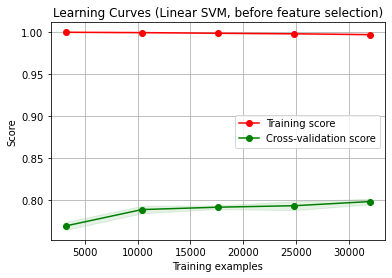

In [9]:
svm = LinearSVC()
title = "Learning Curves (Linear SVM, before feature selection)"
plot_learning_curves(svm, title, X, y, n_jobs=-1)

Run the model with feature selection

In [18]:
fselect = GenericUnivariateSelect(chi2, mode='percentile', param=15)
X_new = fselect.fit_transform(X, y)

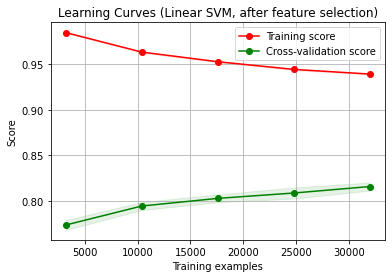

In [19]:
svm = LinearSVC()
title = "Learning Curves (Linear SVM, after feature selection)"
plot_learning_curves(svm, title, X_new, y, n_jobs=-1)

Hyperparameter tuning

In [22]:
# define models and parameters
model = LinearSVC(random_state=0)
losses = ['hinge', 'squared_hinge']
penalties = ['l1', 'l2']
multi_classes = ['ovr', 'crammer_singer']

# define grid search
grid = dict(loss=losses, penalty=penalties, multi_class=multi_classes)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_new, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    if mean != 0:
        print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.815825 using {'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.811950 (0.006299) with: {'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.813975 (0.005452) with: {'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.813975 (0.005452) with: {'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.815825 (0.004449) with: {'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l2'}
0.813975 (0.005452) with: {'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.813975 (0.005452) with: {'loss': 'squared_hinge', 'multi_class': 'crammer_singer', 'penalty': 'l2'}


Run the model after hyperparameter tuning

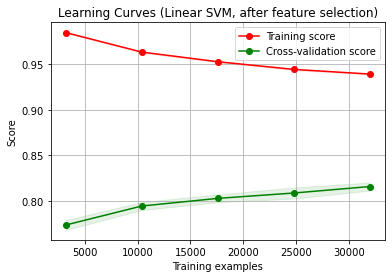

In [23]:
svm = LinearSVC(loss='squared_hinge', multi_class='ovr', penalty='l2')
title = "Learning Curves (Linear SVM, after feature selection)"
plot_learning_curves(svm, title, X_new, y, n_jobs=-1)

Predict Kaggle test set

In [33]:
X_train = preprocess(df_train)
X_test = preprocess(df_test)
X = np.concatenate((X_train, X_test), axis=0)
y_train = df_train['duration_label']

vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
vectorizer.fit(X)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

fselect = GenericUnivariateSelect(chi2, mode='percentile', param=15)
fselect.fit(X_train, y_train)
X_train_new = fselect.transform(X_train)
X_test_new = fselect.transform(X_test)

svm = LinearSVC(loss='squared_hinge', multi_class='ovr', penalty='l2')
svm.fit(X_train, y_train)
predicts = svm.predict(X_test)

# save output as output.csv
ids = np.array(range(len(predicts))) + 1
output = pd.DataFrame({'id': ids, 'duration_label': predicts})
output.to_csv('output.csv', index=False)